# Modelos Generativos basados en Redes Neuronales Profundas

La siguiente figura resume los 4 tipos de modelos generativos basados en redes neuronales:

<p align="center">
    <img src="https://drive.google.com/uc?id=1aKbPicYt534xD1xM4CIVLKPrbCEOvKor" width="600" />
</p>

Todos estos modelos establecen un espacio latente representado por una variable oculta $z$, a partir del cual se pueden generar nuevas instancias de la variable observable $x$, como ser imágenes, por ejemplo.

Estas arquitecturas generalizan el concepto de las mezclas gaussianas a un número infinito de componentes, donde la variable latente $z$
asume valores continuos en lugar de discretos, permitiendo una representación más flexible y rica de los datos.

En este cuaderno, nos centraremos específicamente en los **Autoencoders Variacionales (VAEs)**. De manera análoga a los Modelos de Mezclas Gaussianas (GMMs), los VAEs también buscan maximizar el ELBO o Evidence Lower BOund.

### Dataset

Continuamos trabajando con el dataset FashionMNIST, asi podemos analizar comparativamente el desempeño de los diferentes modelos generativos.  

In [ ]:
#@title Inicializacion


# Importa los módulos
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from tqdm import tqdm


# Definicion de variables globales
BATCH_SIZE = 20     # Tamaño de lote
IMG_SIZE = 32       # Tamaño de la imagen
C_IN = 1            # Numero de canales de entrada

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

DEVICE

'cuda'

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.23MB/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



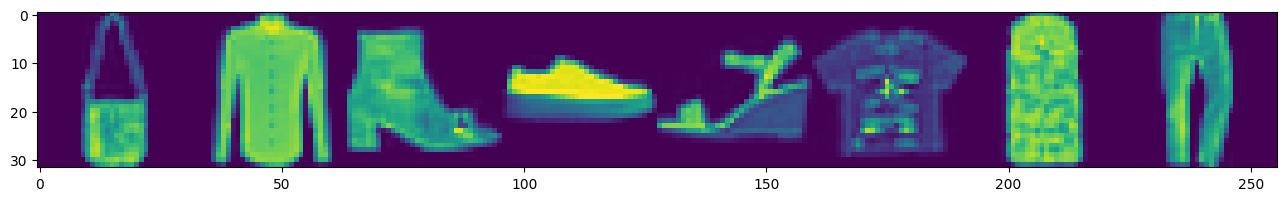

In [ ]:
#@title Carga y preprocesamiento de los datos

# Define una función para cargar y transformar los datos de entrada
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),    # Cambia el tamaño de las imágenes
        transforms.RandomHorizontalFlip(),          # Aplica un volteo horizontal aleatorio a las imágenes, lo que ayuda a aumentar la variedad de datos para mejorar la generalización del modelo.
        transforms.ToTensor(),                      # Convierte las imagenes a tensores de PyTorch, escalando automáticamente los valores de píxeles a un rango [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1)    # Aplica una transformación para escalar los valores de los tensores de [0, 1] a [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms) # Combina las transformaciones definidas en data_transforms en un único objeto que se aplicará a las imágenes de forma secuencial.

    # Descarga el conjunto de datos de entrenamiento (train=True) de FashionMNIST (si no está disponible localmente) en el directorio actual (root="."), aplicando las transformaciones definidas.
    data = torchvision.datasets.FashionMNIST(root=".", download=True, train=True, transform=data_transform)
    return data

# Define una función para mostrar las imágenes
def plot_images(images, title=None):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    if title:
      plt.title(title)
    plt.show()


data = load_transformed_dataset()

# Crea un generador que itera sobre el conjunto de datos para particinarlos en lotes
dataloader = DataLoader(data,
                        batch_size=BATCH_SIZE, # Tamaño de cada lote
                        shuffle=True,          # Mezcla aleatoriamente los datos antes de iterarlos
                        drop_last=True         # Descarta el último lote si no tiene el tamaño completo
                        )
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## Autoencoder Variacional (VAE)

Un VAE consta de dos Redes Neuronales: un codificador (encoder) y un decodificador (decoder). El codificador transforma los datos de entrada en un espacio latente $z$, donde los datos están representados por distribuciones de probabilidad. A partir de muestras tomadas de este espacio latente, el decodificador genera los datos de salida.

In [ ]:
#@title Definición del Modelo

# Clase que define el Codificador Variacional (Variational Encoder)
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        self.input_dim = input_dim                              # Dimensión de entrada
        self.hidden_dim = hidden_dim                            # Dimensión de la capa oculta
        self.latent_dim = latent_dim                            # Dimensión del espacio latente

        # Definición de las capas del codificador
        self.fc1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),         # Capa lineal que transforma la entrada a la dimensión oculta
            nn.BatchNorm1d(hidden_dim),                         # Normalización por lotes para estabilizar el entrenamiento
            nn.ReLU(),                                          # Función de activación ReLU
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),   # Segunda capa lineal, reduciendo la dimensionalidad
            nn.BatchNorm1d(self.hidden_dim // 2),               # Normalización por lotes para esta capa
            nn.ReLU(),  # Función de activación ReLU
        )

        # Capas lineales para calcular la media y la varianza logarítmica del espacio latente
        self.fc2_mean = nn.Linear(hidden_dim // 2, latent_dim)    # Media
        self.fc2_logvar = nn.Linear(hidden_dim // 2, latent_dim)  # Varianza logarítmica

    # Método forward para el paso hacia adelante
    def forward(self, x):
        h = self.fc1(x)  # Pasa la entrada por las capas iniciales

        mean = self.fc2_mean(h)         # Calcula la media del espacio latente
        logvar = self.fc2_logvar(h)     # Calcula la varianza logarítmica

        # Reparametrización: mu + sigma * epsilon, donde epsilon es ruido aleatorio

        std = torch.exp(0.5 * logvar)  # Calcula la desviación estándar
        eps = torch.randn_like(std)    # Genera ruido aleatorio del mismo tamaño que std
        z = mean + eps * std           # Vector latente reparametrizado
        # Nota: Sin el truco de reparametrización, z dependería directamente de una operación de muestreo no diferenciable (como torch.randn)
        return z, mean, logvar         # Devuelve el vector latente y los parámetros del espacio latente


# Clase que define el Decodificador
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim  # Dimensión del espacio latente
        self.hidden_dim = hidden_dim  # Dimensión de la capa oculta
        self.output_dim = output_dim  # Dimensión de salida (reconstrucción)

        # Definición de las capas del decodificador
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),  # Primera capa lineal
            nn.ReLU(),  # Activación ReLU
            nn.Linear(hidden_dim // 2, hidden_dim),  # Segunda capa lineal
            nn.ReLU(),  # Activación ReLU
            nn.Linear(hidden_dim, output_dim),  # Capa final que produce la salida reconstruida
            nn.Tanh(),  # Activación Tanh para la salida (útil si los datos están normalizados entre -1 y 1)
        )

    # Método forward para el paso hacia adelante
    def forward(self, z):
        h = self.fc(z)  # Pasa el vector latente a través del decodificador
        return h  # Devuelve la reconstrucción


# Clase que define el Autoencoder Variacional (VAE)
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.latent_dim = latent_dim  # Dimensión del espacio latente
        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)  # Codificador
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)  # Decodificador

    # Método forward para el paso hacia adelante del autoencoder
    def forward(self, x):
        z, _, _ = self.encoder(x)  # Obtiene el vector latente del codificador
        return self.decoder(z)  # Decodifica el vector latente para reconstruir la entrada

### Entrenamiento de un VAE

Para entrenar un modelo de VAE, nos gustaría maximizar la log-verosimilitud marginal $\max_{w} \log p(X \mid w)$ de nuestro conjunto de datos (notese que aqui usamos $w$ en lugar de $\theta$ para representar los parametros). Sin embargo, esto es computacionalmente muy complejo, por lo que en su lugar maximizamos la Cota Inferior Variacional (ELBO) o $\mathcal{L}(w,q)$ con respecto a los parámetros $w$ y las distribuciones variacionales $q$.


$$\log p(X \mid w) \geq \mathcal{L}(w, q)  $$

 $\mathcal{L}(w,q)$ esta dada por:

$$ \mathcal{L}(w,q) = \int q(z|x,\phi) \log p(x|z, w) dz
- \sum_{i=1}^N \text{KL}(q(z|x,\phi) \mid\mid p(z))  $$



Recordemos que para el modelo GMM, el ELBO se optimizaba iterativamente mediante el algoritmo EM, alternando entre actualizar las distribuciones variacionales $q$ en el paso E y los parámetros $w$ del modelo en el paso M.

En cambio en un VAE, $q$ y $w$ se obtienen mediante dos redes neuronales, denominadas encoder y decoder, respectivamente, que tienen parámetros independientes entre si y se entrenan de manera simultánea (en un solo paso) para maximizar $ \mathcal{L}(w,q)$.

El segundo término de $KL$ actúa como un regularizador, evitando que la distribución $q$ se desvíe demasiado de una distribución normal estándar, definida por $p(z)$.

El primer termino de $\mathcal{L}(w,q)$ mide la perdida de reconstrucción de los datos originales. El encoder $q(z|x,\phi)$, con parámetros $\phi$ toma un vector de datos $x$ y lo mapea a un espacio latente $z$. A su vez el decoder $p(x|z,w)$ con parámetros $w$,  toma un vector del espacio latente $z$ y lo mapea de vuelta al espacio de datos $x$.

Esta perdida de recosntrucción es similar a un modelo de autoencoder simple, excepto que ahora definimos una distribución de probabilidad sobre el espacio latente, al imponer una distribución normal para el codificador.  


![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1)

Una elección típica para el encoder es una distribución gaussiana con una matriz de covarianza diagonal, cuyos parámetros de media y covarianza, $ m_j $ y $ s_j $, son proporcionados por las salidas de una red neuronal que toma $ x $ como entrada:

$$
q(z|x, \phi) = \prod_{j=1}^{M} \mathcal{N}(z_j | m_j(x, \phi), s_j(x, \phi)).
$$




In [ ]:
#@title Entrenamiento

# Clase para manejar el Autoencoder Variacional (VAE)
class VAEManager():
    def __init__(self, input_dim, hidden_dim, latent_dim, lr):
        # Inicializa el modelo VAE y lo mueve al dispositivo adecuado (CPU/GPU)
        self.vae = VariationalAutoEncoder(input_dim, hidden_dim, latent_dim).to(DEVICE)

        # Define el optimizador Adam para entrenar el modelo
        self.optimizer = torch.optim.Adam(self.vae.parameters(), lr=lr)

        # Programa de reducción del learning rate basado en la pérdida
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5, verbose=True)

        # Define la función de pérdida de error cuadrático medio (MSE)
        self.loss = nn.MSELoss(reduction='sum')

    # Método para entrenar el modelo
    def train(self, dataloader, epochs):
        # Historial para registrar las pérdidas durante el entrenamiento
        history = dict(loss=[])

        for epoch in range(epochs):
            total_loss = []  # Lista para acumular la pérdida de cada batch

            # Itera sobre los batches del dataloader
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                # Prepara los datos de entrada (aplana las imágenes)
                batch_x = batch_x.squeeze(1).view(BATCH_SIZE, -1).to(DEVICE)

                # Pasa los datos por el codificador para obtener el espacio latente
                z, mean, logvar = self.vae.encoder(batch_x)

                # Reconstruye las imágenes a partir del espacio latente
                reconstructed = self.vae.decoder(z)

                # Calcula la pérdida de reconstrucción (MSE)
                reconstruction_loss = self.loss(reconstructed, batch_x)

                # Calcula la pérdida KL-divergence para regularizar el espacio latente
                kl_loss = 0.5 * torch.sum(-1 - logvar + mean.pow(2) + logvar.exp())

                # Pérdida total (reconstrucción + regularización)
                loss = reconstruction_loss + kl_loss

                # Optimiza los parámetros del modelo
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Registra la pérdida normalizada por batch
                total_loss.append(loss.item() / batch_x.size(0))

            # Calcula la pérdida media de la época
            mean_loss = np.mean(total_loss)
            # Actualiza el learning rate basado en la pérdida media
            self.scheduler.step(mean_loss)

            # Imprime el progreso del entrenamiento
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch + 1, epochs, mean_loss)
            )

            # Genera muestras de imágenes para monitorear el entrenamiento
            self.sample(8, plot=False)

            # Guarda la pérdida en el historial
            history['loss'].append(mean_loss)

        # Retorna el historial de pérdidas
        return history

    # Método para generar muestras desde el espacio latente
    def sample(self, n, plot=True):
        # Genera dos vectores latentes aleatorios
        z1 = torch.randn(1, self.vae.latent_dim).to(DEVICE)
        z2 = torch.randn(1, self.vae.latent_dim).to(DEVICE)

        # Interpola entre los dos vectores para generar nuevos puntos en el espacio latente
        zs = torch.zeros((n, self.vae.latent_dim)).to(DEVICE)
        for i in range(n):
            alpha = i / (n - 1)  # Factor de interpolación
            zs[i] = (1 - alpha) * z1 + alpha * z2

        # Decodifica los puntos del espacio latente para obtener imágenes
        with torch.no_grad():
            images = torch.cat([self.vae.decoder(z) for z in zs], dim=0).view(n, 1, 32, 32).detach()

            # Si está activada la opción de graficar, muestra las imágenes
            if plot:
                plot_images(images)

            # Retorna las imágenes generadas
            return images


vae = VAEManager(
    32 * 32,
    hidden_dim=256,
    latent_dim=64,
    lr=0.0002
)
vae_history = vae.train(dataloader, epochs=40)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 3000/3000 [00:26<00:00, 114.03it/s]


[Epoch: 1/40] [loss: 140.0126]


100%|██████████| 3000/3000 [00:26<00:00, 114.46it/s]


[Epoch: 2/40] [loss: 102.1998]


100%|██████████| 3000/3000 [00:26<00:00, 114.16it/s]


[Epoch: 3/40] [loss: 90.9305]


100%|██████████| 3000/3000 [00:26<00:00, 114.23it/s]


[Epoch: 4/40] [loss: 83.8767]


100%|██████████| 3000/3000 [00:26<00:00, 114.75it/s]


[Epoch: 5/40] [loss: 79.0582]


100%|██████████| 3000/3000 [00:26<00:00, 112.49it/s]


[Epoch: 6/40] [loss: 75.6758]


100%|██████████| 3000/3000 [00:26<00:00, 112.73it/s]


[Epoch: 7/40] [loss: 73.4214]


100%|██████████| 3000/3000 [00:26<00:00, 114.29it/s]


[Epoch: 8/40] [loss: 71.7292]


100%|██████████| 3000/3000 [00:26<00:00, 114.06it/s]


[Epoch: 9/40] [loss: 70.4380]


100%|██████████| 3000/3000 [00:26<00:00, 112.17it/s]


[Epoch: 10/40] [loss: 69.7690]


100%|██████████| 3000/3000 [00:27<00:00, 110.96it/s]


[Epoch: 11/40] [loss: 68.8187]


100%|██████████| 3000/3000 [00:28<00:00, 104.51it/s]


[Epoch: 12/40] [loss: 68.3082]


100%|██████████| 3000/3000 [00:26<00:00, 111.99it/s]


[Epoch: 13/40] [loss: 67.6549]


100%|██████████| 3000/3000 [00:26<00:00, 112.91it/s]


[Epoch: 14/40] [loss: 66.9514]


100%|██████████| 3000/3000 [00:26<00:00, 114.33it/s]


[Epoch: 15/40] [loss: 66.5273]


100%|██████████| 3000/3000 [00:26<00:00, 113.72it/s]


[Epoch: 16/40] [loss: 66.1707]


100%|██████████| 3000/3000 [00:26<00:00, 111.60it/s]


[Epoch: 17/40] [loss: 65.6249]


100%|██████████| 3000/3000 [00:26<00:00, 115.01it/s]


[Epoch: 18/40] [loss: 65.2481]


100%|██████████| 3000/3000 [00:26<00:00, 111.82it/s]


[Epoch: 19/40] [loss: 65.0593]


100%|██████████| 3000/3000 [00:26<00:00, 114.79it/s]


[Epoch: 20/40] [loss: 64.7211]


100%|██████████| 3000/3000 [00:26<00:00, 115.06it/s]


[Epoch: 21/40] [loss: 64.5456]


100%|██████████| 3000/3000 [00:26<00:00, 115.36it/s]


[Epoch: 22/40] [loss: 64.2692]


100%|██████████| 3000/3000 [00:26<00:00, 114.46it/s]


[Epoch: 23/40] [loss: 63.9988]


100%|██████████| 3000/3000 [00:26<00:00, 114.94it/s]


[Epoch: 24/40] [loss: 63.9253]


100%|██████████| 3000/3000 [00:27<00:00, 110.99it/s]


[Epoch: 25/40] [loss: 63.5221]


100%|██████████| 3000/3000 [00:27<00:00, 110.52it/s]


[Epoch: 26/40] [loss: 63.4240]


100%|██████████| 3000/3000 [00:26<00:00, 112.27it/s]


[Epoch: 27/40] [loss: 63.2329]


100%|██████████| 3000/3000 [00:26<00:00, 114.49it/s]


[Epoch: 28/40] [loss: 63.0300]


100%|██████████| 3000/3000 [00:26<00:00, 112.38it/s]


[Epoch: 29/40] [loss: 62.9765]


100%|██████████| 3000/3000 [00:26<00:00, 112.42it/s]


[Epoch: 30/40] [loss: 62.7428]


100%|██████████| 3000/3000 [00:26<00:00, 113.17it/s]


[Epoch: 31/40] [loss: 62.4324]


100%|██████████| 3000/3000 [00:26<00:00, 114.30it/s]


[Epoch: 32/40] [loss: 62.4419]


100%|██████████| 3000/3000 [00:27<00:00, 110.99it/s]


[Epoch: 33/40] [loss: 62.3148]


100%|██████████| 3000/3000 [00:26<00:00, 115.12it/s]


[Epoch: 34/40] [loss: 62.2321]


100%|██████████| 3000/3000 [00:26<00:00, 114.32it/s]


[Epoch: 35/40] [loss: 62.0478]


100%|██████████| 3000/3000 [00:26<00:00, 114.56it/s]


[Epoch: 36/40] [loss: 62.0054]


100%|██████████| 3000/3000 [00:25<00:00, 115.92it/s]


[Epoch: 37/40] [loss: 61.9183]


100%|██████████| 3000/3000 [00:26<00:00, 115.27it/s]


[Epoch: 38/40] [loss: 61.7815]


100%|██████████| 3000/3000 [00:25<00:00, 115.47it/s]


[Epoch: 39/40] [loss: 61.6147]


100%|██████████| 3000/3000 [00:26<00:00, 114.08it/s]

[Epoch: 40/40] [loss: 61.5187]


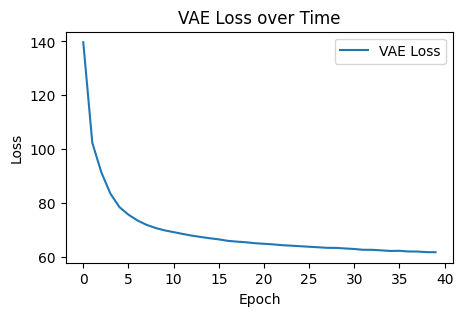

In [ ]:
#@title Graficar la perdida del VAE

def plot_losses(vae_history):
    figsize = (5, 3)
    plt.figure(figsize=figsize)
    plt.plot(vae_history['loss'], label='VAE Loss')
    plt.title('VAE Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(vae_history)

## Muestreo del espacio latente


### Truco de reparametrización
Para aproximar la integral sobre $z_n$ en el primer termino de $\mathcal{L}$, se realiza un muestreo por Monte Carlo del espacio latente,

$$  \int q(z_n | x_n, \phi) \log p(x_n | z_n, w) \, dz_n \approx \frac{1}{L} \sum_{l=1}^{L} \log p(x_n | z_{n}^{(l)}, w) $$

donde $\{z_n\}$ son muestras tomadas de la distribución $q(z|x,\phi)$. Durante el entrenamiendo debemos calcular los gradientes de esta cantidad con respecto a $w$ y $\phi$. Calcular el gradiente con respecto a $w$ es fácil, pero el gradiente con respecto a $\phi$ es problemático porque los cambios en $\phi$ alterarán la distribución $q(z_n | x_n, \phi)$ de la cual se extraen las muestras, y sin embargo, estas muestras son valores fijos, lo que impide obtener las derivadas con respecto a $\phi$.  

Podemos resolver esto empleando el **truco de reparametrización** que sugiere que, en lugar de muestrear de la distribución $ z \sim q(z \mid x, \phi) $, se debe muestrear de una distribución $\epsilon$ que no dependa de ningún parámetro, como por ejemplo una distribución normal estándar, $\epsilon \sim \mathcal{N}(0, I)$. Luego, utilizamos las muestras de $\epsilon$ para evaluar deterministicamente el valor de $z$:

$$ z = m(x, \phi) + \varepsilon \cdot s(x, \phi) $$

donde $m(x, \phi)$ y $s(x, \phi)$ estan definidos por las salidas del encoder.


### VAE en régimen generativo
Una vez entrenado el modelo, podemos generar nuevas imágenes de prendas muestreando directamente $z$ de la distribución a priori $p(z)$, que típicamente se elige como una distribución normal estándar:

$$ z \sim \mathcal{N}(0, I) $$

Sin embargo, en este caso, el modelo tiende a "alucinar", es decir, a generar imágenes que no son coherentes o que carecen de sentido visual, ya que no está condicionado a datos reales.

En cambio, se obtienen mejores resultados cuando se muestrea de la distribucion *a posteriori* aproximada $q(z|x,\phi)$. Para ello utilizamos el codificador para transformar un conjunto de imagenes existentes $x$ en el espacio latente, obteniendo así los parámetros de la distribución $ q(z|x,\phi) $, que incluye la media $ m $ y la desviación estándar $ s $. Luego aplicamos el truco de reparametrización para obtener un nuevo valor de $ z $,  

$$ z = m(x, \phi) + \epsilon \cdot s(x, \phi) $$

Finalmente, pasamos el valor muestreado $ z $ al decodificador $ p(x|z,w) $ para generar una nueva imagen de la prenda correspondiente.

Veamos algunos ejemplos en la practica.

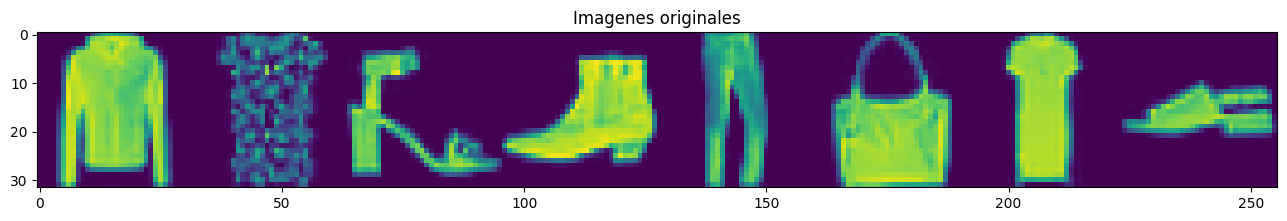

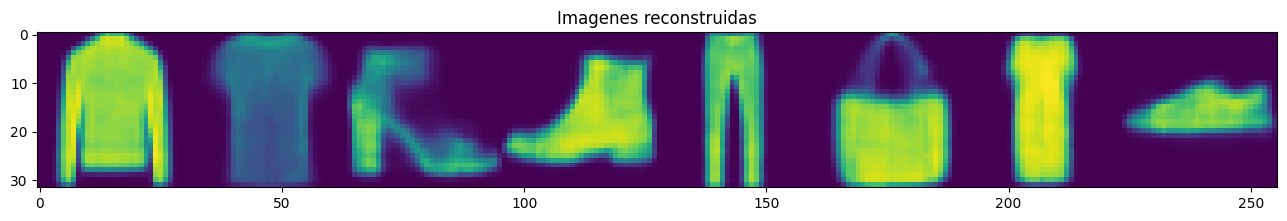

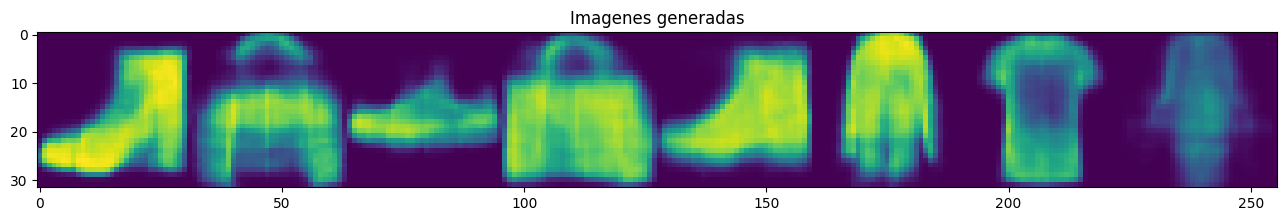

In [ ]:
#@title Generación de imágenes

def compare_training_vs_generative(vae, dataloader, n=8):
    """Comparar reconstrucción y generación de imágenes."""
    # Reconstrucción
    batch = next(iter(dataloader))
    original_images = batch[0][:n].to(DEVICE).squeeze(1).view(n, -1)
    with torch.no_grad():
        z, _, _ = vae.vae.encoder(original_images)
        reconstructed_images = vae.vae.decoder(z)

    # Generación de nuevas imágenes
    with torch.no_grad():
        random_z = torch.randn(n, vae.vae.latent_dim).to(DEVICE)
        generated_images = vae.vae.decoder(random_z)

    # Visualizar todas juntas
    plot_images(original_images.view(n, 1, 32, 32), title="Imagenes originales")
    plot_images(reconstructed_images.view(n, 1, 32, 32), title="Imagenes reconstruidas")
    plot_images(generated_images.view(n, 1, 32, 32), title="Imagenes generadas")

compare_training_vs_generative(vae, dataloader, n=8)

## Preguntas:

1. ¿Qué diferencias notas entre las reconstrucciones y las imágenes generadas? ¿A que piensas que se deben esas diferencias?

2. ¿Cómo afecta el tamaño del espacio latente a las imágenes generadas? Probar con un espacio latante de mayor/menor dimension

